In [17]:
#!pip install openpyxl

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def mouse_event(event):
   global pos
   print('x: {} and y: {}'.format(event.xdata, event.ydata))
   pos.append([event.xdata,event.ydata])

In [19]:
def getData():
    d = pd.read_excel('./data/Ammoniac-TTF.xlsx',sheet_name='Feuil1',index_col=None, header=None)
    return d

In [20]:
def prepareData():
    data = getData()
    data = data.rename(columns={ 1:'NH3', 2:'TTF'})
    data = data.drop([0,1])
    data = data.set_index(0)
    newS = pd.Series()
    for i in range(data['NH3'].size):
        id = data.index[i]
        v =  id.year
        newS[id] = v
        # print(v)
    data['Annee'] = newS
    m_min = data['NH3'].min()
    m_max = data['NH3'].max()
    g_min = data['TTF'].min()
    g_max = data['TTF'].max()
    return data,m_min,m_max,g_min,g_max

In [21]:
def map_(v,x1,x2,y1,y2):
    ret = (v-x1)/(x2-x1) * (y2-y1) + y1
    return ret

In [22]:
def allData():
    data, m_min,m_max,g_min,g_max = prepareData()
    market_mini = 220
    market_maxi = 1630
    gaz_mini = 4
    gaz_maxi = 235
    inc=10
    market_nb= (market_maxi-market_mini)/inc
    gaz_nb = (gaz_maxi-gaz_mini)/1
    market_list = np.array([i for i in range(market_mini,market_maxi,inc)])
    gaz_list = np.array([i for i in range(gaz_mini,gaz_maxi,1)])
    # gaz_list = gaz_list.sort()
    # gaz_list = gaz_list[::-1]
    return data,market_list,gaz_list

In [109]:
# Parametres ...
B_fee = 23
B_margin = 27
B_Transport = 60
B_gaz_tax = 3.74
B_gaz = 10.6
F_feeM = 15
F_EUA = 1.3
F_gaz = 11
F_Power = 0.25
F_feeG = 90 #90
F_margin = 125
F_Transport = 52.15

In [157]:
B_sel = ['Market','Gas']
def get_price_B(market,gaz,FX):
    price_m = market / FX + B_fee + B_Transport
    price_g = (gaz+B_gaz_tax) * B_gaz + B_fee + B_margin + B_Transport
    sel = np.argsort([price_m, price_g])
    price = max(price_g,price_m)
    return price,price_m,price_g, sel[1]

In [159]:
F_sel = ['Market','Gas','Gas+']
def get_price_F(market,gaz,FX,EUA, power):
    price_m = market / FX + F_feeM + F_Transport
    price_g = gaz * F_gaz + F_feeG + EUA*F_EUA + power*F_Power + F_Transport
    price_gPlus = price_g + F_margin
    prices = np.array([price_m,price_g,price_gPlus])
    sel = np.argsort(prices)
    prices = np.sort(prices)
    price = prices[1]
    return price,price_m,price_g,price_gPlus,sel[1]

In [190]:
market = 760
gaz = 53
power = 75
EUA = 56.1
FX = 1.08
pB,t,u,selB = get_price_B(market=market, gaz=gaz, FX=FX)
pF,a,b,c,selF = get_price_F(market=market, gaz=gaz, FX=FX,EUA=EUA, power=power)
print(int(pB-pF),pB,B_sel[selB],t,u, pF,F_sel[selF],a,b,c)

0 786.7037037037037 Market 786.7037037037037 711.444 786.83 Gas 770.8537037037037 786.83 911.83


In [193]:
# Génération de la matrice [Market x Gaz]
def generationDF(market_list,gaz_list,EUA=80.0,power=75.0,FX=1.08):
    df = pd.DataFrame(columns=market_list)
    dfB = pd.DataFrame(columns=market_list)
    dfF = pd.DataFrame(columns=market_list)
    dfFsnsC = pd.DataFrame(columns=market_list)
    dfBsnsC = pd.DataFrame(columns=market_list)
    dfColor = pd.DataFrame(columns=market_list)
    for market in market_list:
        pdS = pd.Series()
        pdSB = pd.Series()
        pdSF = pd.Series()
        pdSFsnsC = pd.Series()
        pdSBsnsC = pd.Series()
        pdSColor = pd.Series()
        for gaz in gaz_list:
            pB,_,_,sB = get_price_B(market=market, gaz=gaz, FX=FX)
            pF,_,_,_,sF = get_price_F(market=market, gaz=gaz, FX=FX,EUA=EUA, power=power)
            pdS[gaz] = int(pB-pF)
            pdSB[gaz] = int(pB)
            pdSF[gaz] = int(pF)
            pdSFsnsC[gaz] = sF
            pdSBsnsC[gaz] = sB
            pdSColor[gaz] = 0
        df[market] = pdS
        dfB[market] = pdSB
        dfF[market] = pdSF
        dfFsnsC[market] = pdSFsnsC
        dfBsnsC[market] = pdSBsnsC
        dfColor[market] = pdSColor
    return df, dfColor, dfB, dfF , dfBsnsC, dfFsnsC
#df

In [194]:
def countData(data,dfColor):
    nb = data['NH3'].size
    for n in range(nb):
        gaz = data['TTF'][n]
        nh3 = data['NH3'][n]
        id_gaz = int(gaz)
        id_nh3 = int(round(nh3/10)*10)
        dfColor[id_nh3][id_gaz] = dfColor[id_nh3][id_gaz] + 1
    return dfColor

In [195]:
power = 75
EUA = 65
FX=1.08
data, market_list, gaz_list = allData()
df,dfColor,dfB, dfF, dfBColor, dfFColor = generationDF(market_list,gaz_list,EUA=EUA,power=power,FX=FX)
dfColor = countData(data, dfColor)

C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\2908870414.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gaz = data['TTF'][n]
C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\2908870414.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nh3 = data['NH3'][n]
C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\2908870414.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gaz = data['TTF'][n]
C:\Users\eplaidy\AppData\Loc

In [197]:
a,b,c,d = 7,50,5,55 # gaz / market
df_sns = df.iloc[a:b,c:d]
dfB_sns = dfB.iloc[a:b,c:d]
dfF_sns = dfF.iloc[a:b,c:d]
dfColor_sns = dfColor.iloc[a:b,c:d]
dfFsnsColor = dfFColor.iloc[a:b,c:d]
dfBsnsColor = dfBColor.iloc[a:b,c:d]
sns_gaz = gaz_list[a:b]
sns_market = market_list[c:d]
maxIdxColor = dfColor_sns.max().max()
print(maxIdxColor)

9


In [199]:
x0 = sns_market[0]
x1 = sns_market[-1]
y0 = sns_gaz[0]
y1 = sns_gaz[-1]
print(x0,x1)
print(y0,y1)
n = data['NH3'].size
cpt=0
x_ = np.zeros(n)
y_ = np.zeros(n)
a_ = np.zeros(n)
for i in range(n):
    vx = data['NH3'][i]
    vy = data['TTF'][i]
    if ((vx>=x0) & (vx<=x1) & (vy>=y0) & (vy<=y1) ):
        x_[cpt] = (map_(vx,x0-5,x1+5,0,d-c))
        y_[cpt] = (map_(vy,y0-0.5,y1+0.5,b-a+1,0))
        a_[cpt] = data['Annee'][i]
        cpt+=1
y_= y_[0:cpt-2]
x_= x_[0:cpt-2]
a_= a_[0:cpt-2]
print("nombre de valeurs : ",cpt+1)
dfColor_sns.sum().sum()

270 760
11 53
nombre de valeurs :  412


C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\3146627388.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vx = data['NH3'][i]
C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\3146627388.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vy = data['TTF'][i]
C:\Users\eplaidy\AppData\Local\Temp\ipykernel_29288\3146627388.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_[cpt] = data['Annee'][i]


418

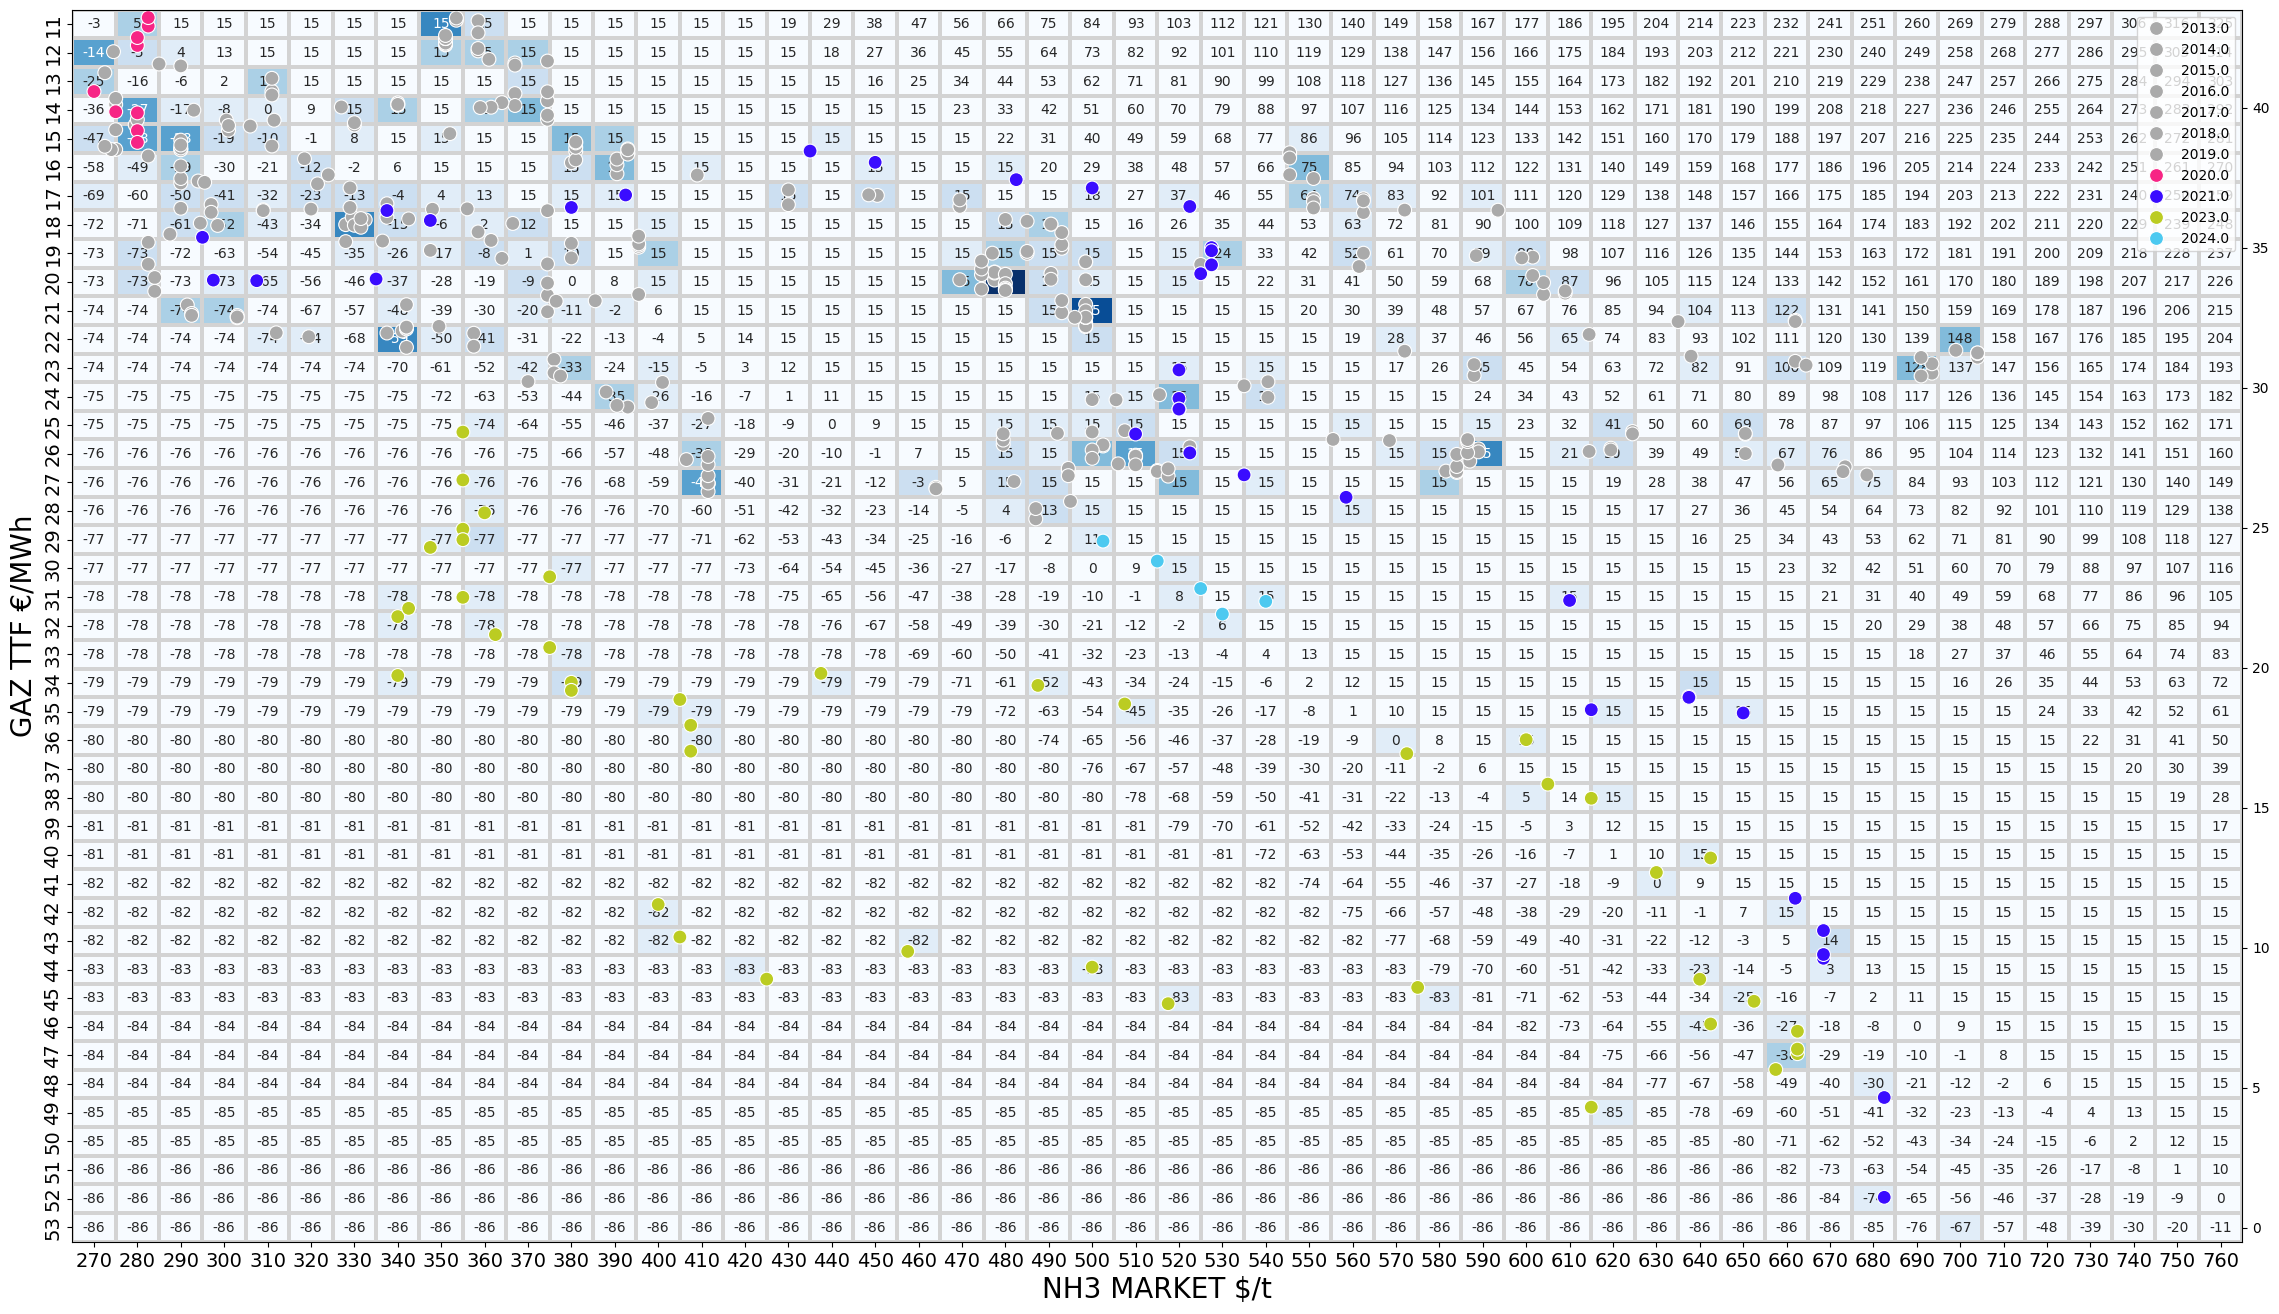

In [200]:
# pos=[]
# plt.rcParams["figure.autolayout"] = True
fig,ax = plt.subplots(figsize=(28,16))
# cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#F72585","#3A0CFF", "#BBCC22", "#4CC9F0"]
# sns.set()  "#F72585", "#7209B7",,"#3A0CA3", "#4361EE", "#4CC9F0
plt.tick_params(bottom='on')
g = sns.heatmap(dfColor_sns.values,annot=df_sns,xticklabels=sns_market, yticklabels=sns_gaz, cmap='Blues' , vmin=0, vmax=maxIdxColor,cbar=False, fmt='d', linewidth=1.5, linecolor='lightgrey', ax=ax );
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('NH3 MARKET $/t',fontsize=20);
g.set_ylabel('GAZ TTF €/MWh',fontsize=20);
ax2 = plt.twinx()
ax2.set(ylim=(-.5, b-a+.5))
ax2.set(xlim=(0, d-c))
sns.scatterplot(x=x_, y=y_, hue=a_, palette=palette, s=100 , ax=ax2);
# ax2.axis('tight');
# plt.draw()


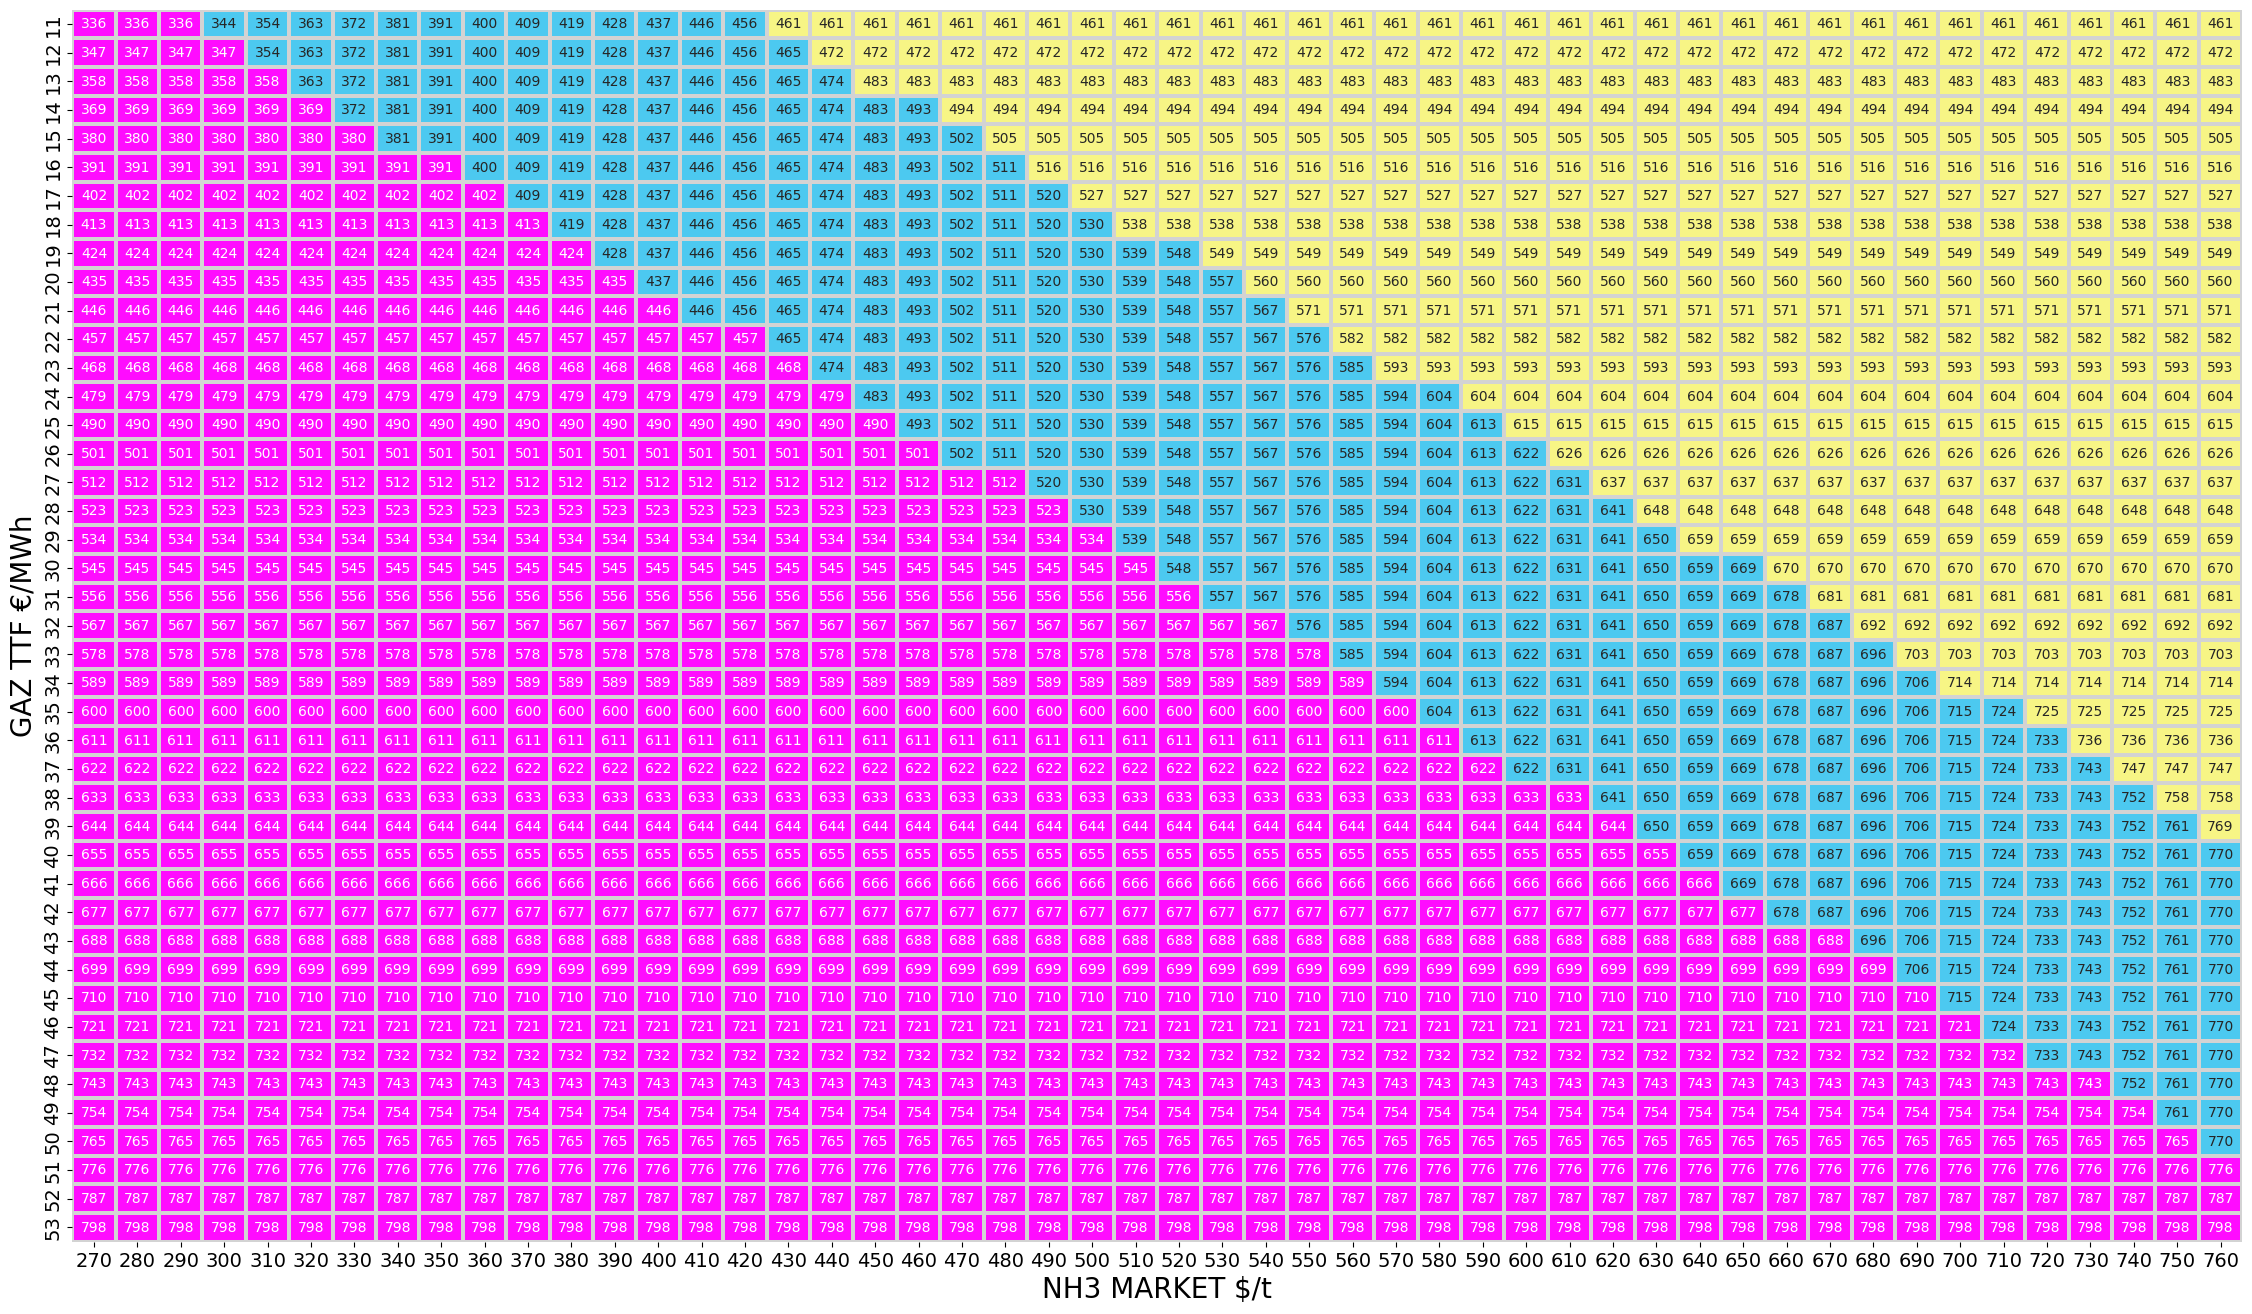

In [215]:
# Only F
fig,ax = plt.subplots(figsize=(28,16))
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#F72585","#3A0CFF", "#BBCC22", "#4CC9F0"]
palette2 = ["#4CC9F0","#FF0CFF", "#F7f585"]
plt.tick_params(bottom='on')
g = sns.heatmap(dfFsnsColor.values,annot=dfF_sns,xticklabels=sns_market, yticklabels=sns_gaz, cmap=palette2 , vmin=0, vmax=2,cbar=False, fmt='d', linewidth=1.5, linecolor='lightgrey', ax=ax );
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('NH3 MARKET $/t',fontsize=20);
g.set_ylabel('GAZ TTF €/MWh',fontsize=20);
# ax2 = plt.twinx()
# ax2.set(ylim=(-.5, b-a+.5))
# ax2.set(xlim=(0, d-c))
# sns.scatterplot(x=x_, y=y_, hue=a_, palette=palette, s=100 , ax=ax2);
# ax2.axis('tight');
# plt.draw()


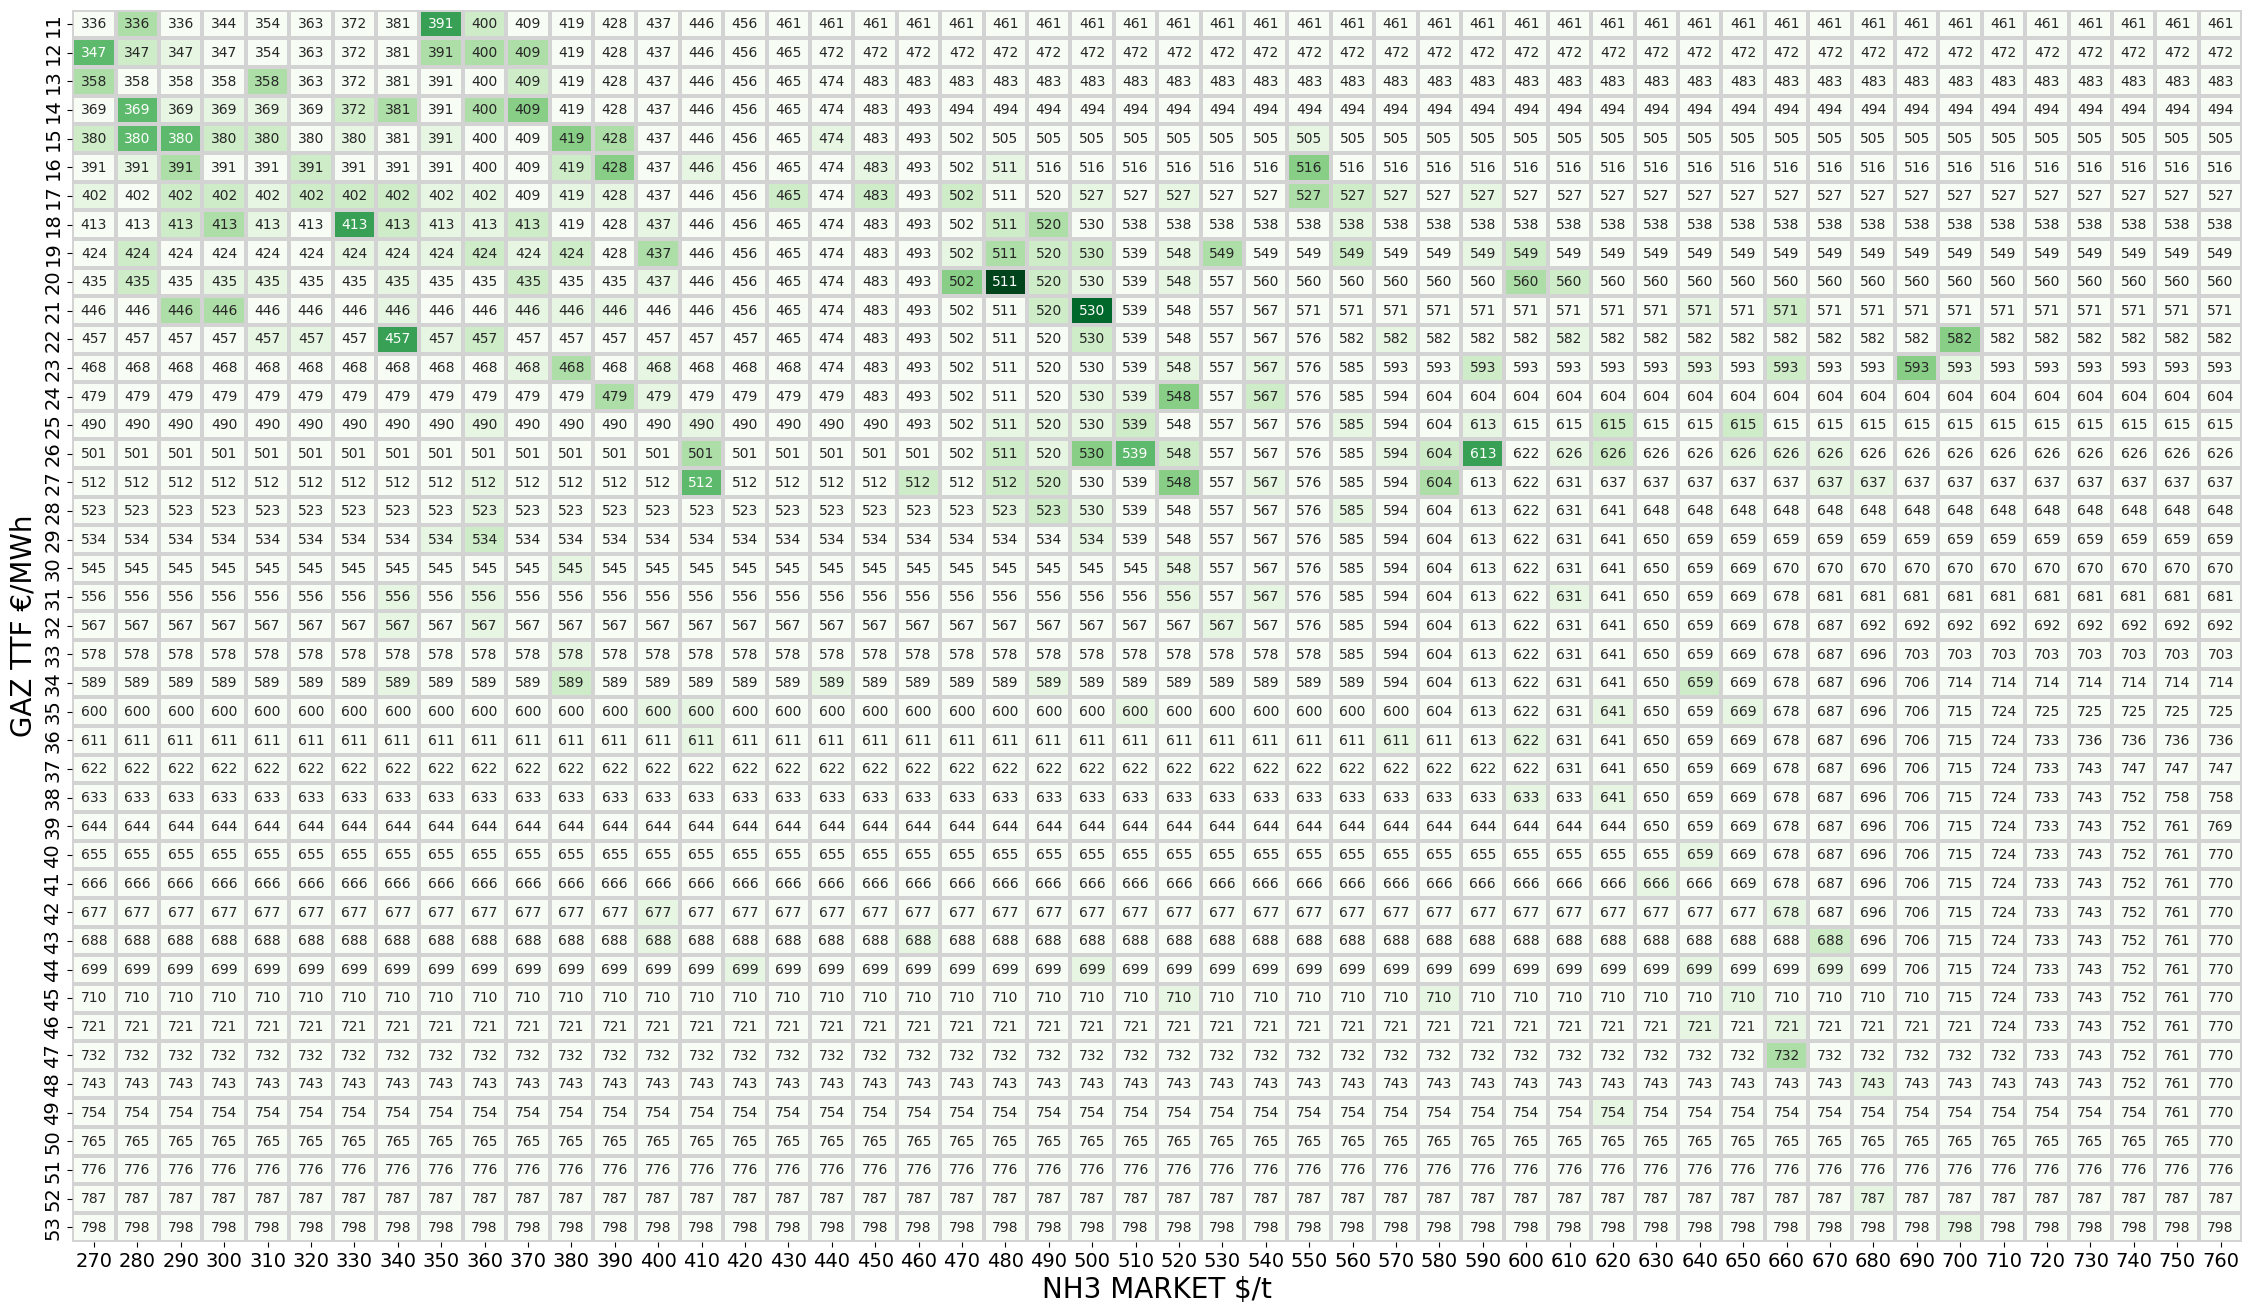

In [202]:
# Only F
fig,ax = plt.subplots(figsize=(28,16))
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#F72585","#3A0CFF", "#BBCC22", "#4CC9F0"]
plt.tick_params(bottom='on')
g = sns.heatmap(dfColor_sns.values, annot=dfF_sns,xticklabels=sns_market, yticklabels=sns_gaz, cmap='Greens' , vmin=0, vmax=maxIdxColor,cbar=False, fmt='d', linewidth=1.5, linecolor='lightgrey', ax=ax );
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('NH3 MARKET $/t',fontsize=20);
g.set_ylabel('GAZ TTF €/MWh',fontsize=20);
# ax2 = plt.twinx()
# ax2.set(ylim=(-.5, b-a+.5))
# ax2.set(xlim=(0, d-c))
# sns.scatterplot(x=x_, y=y_, hue=a_, palette=palette, s=100 , ax=ax2);
# ax2.axis('tight');
# plt.draw()


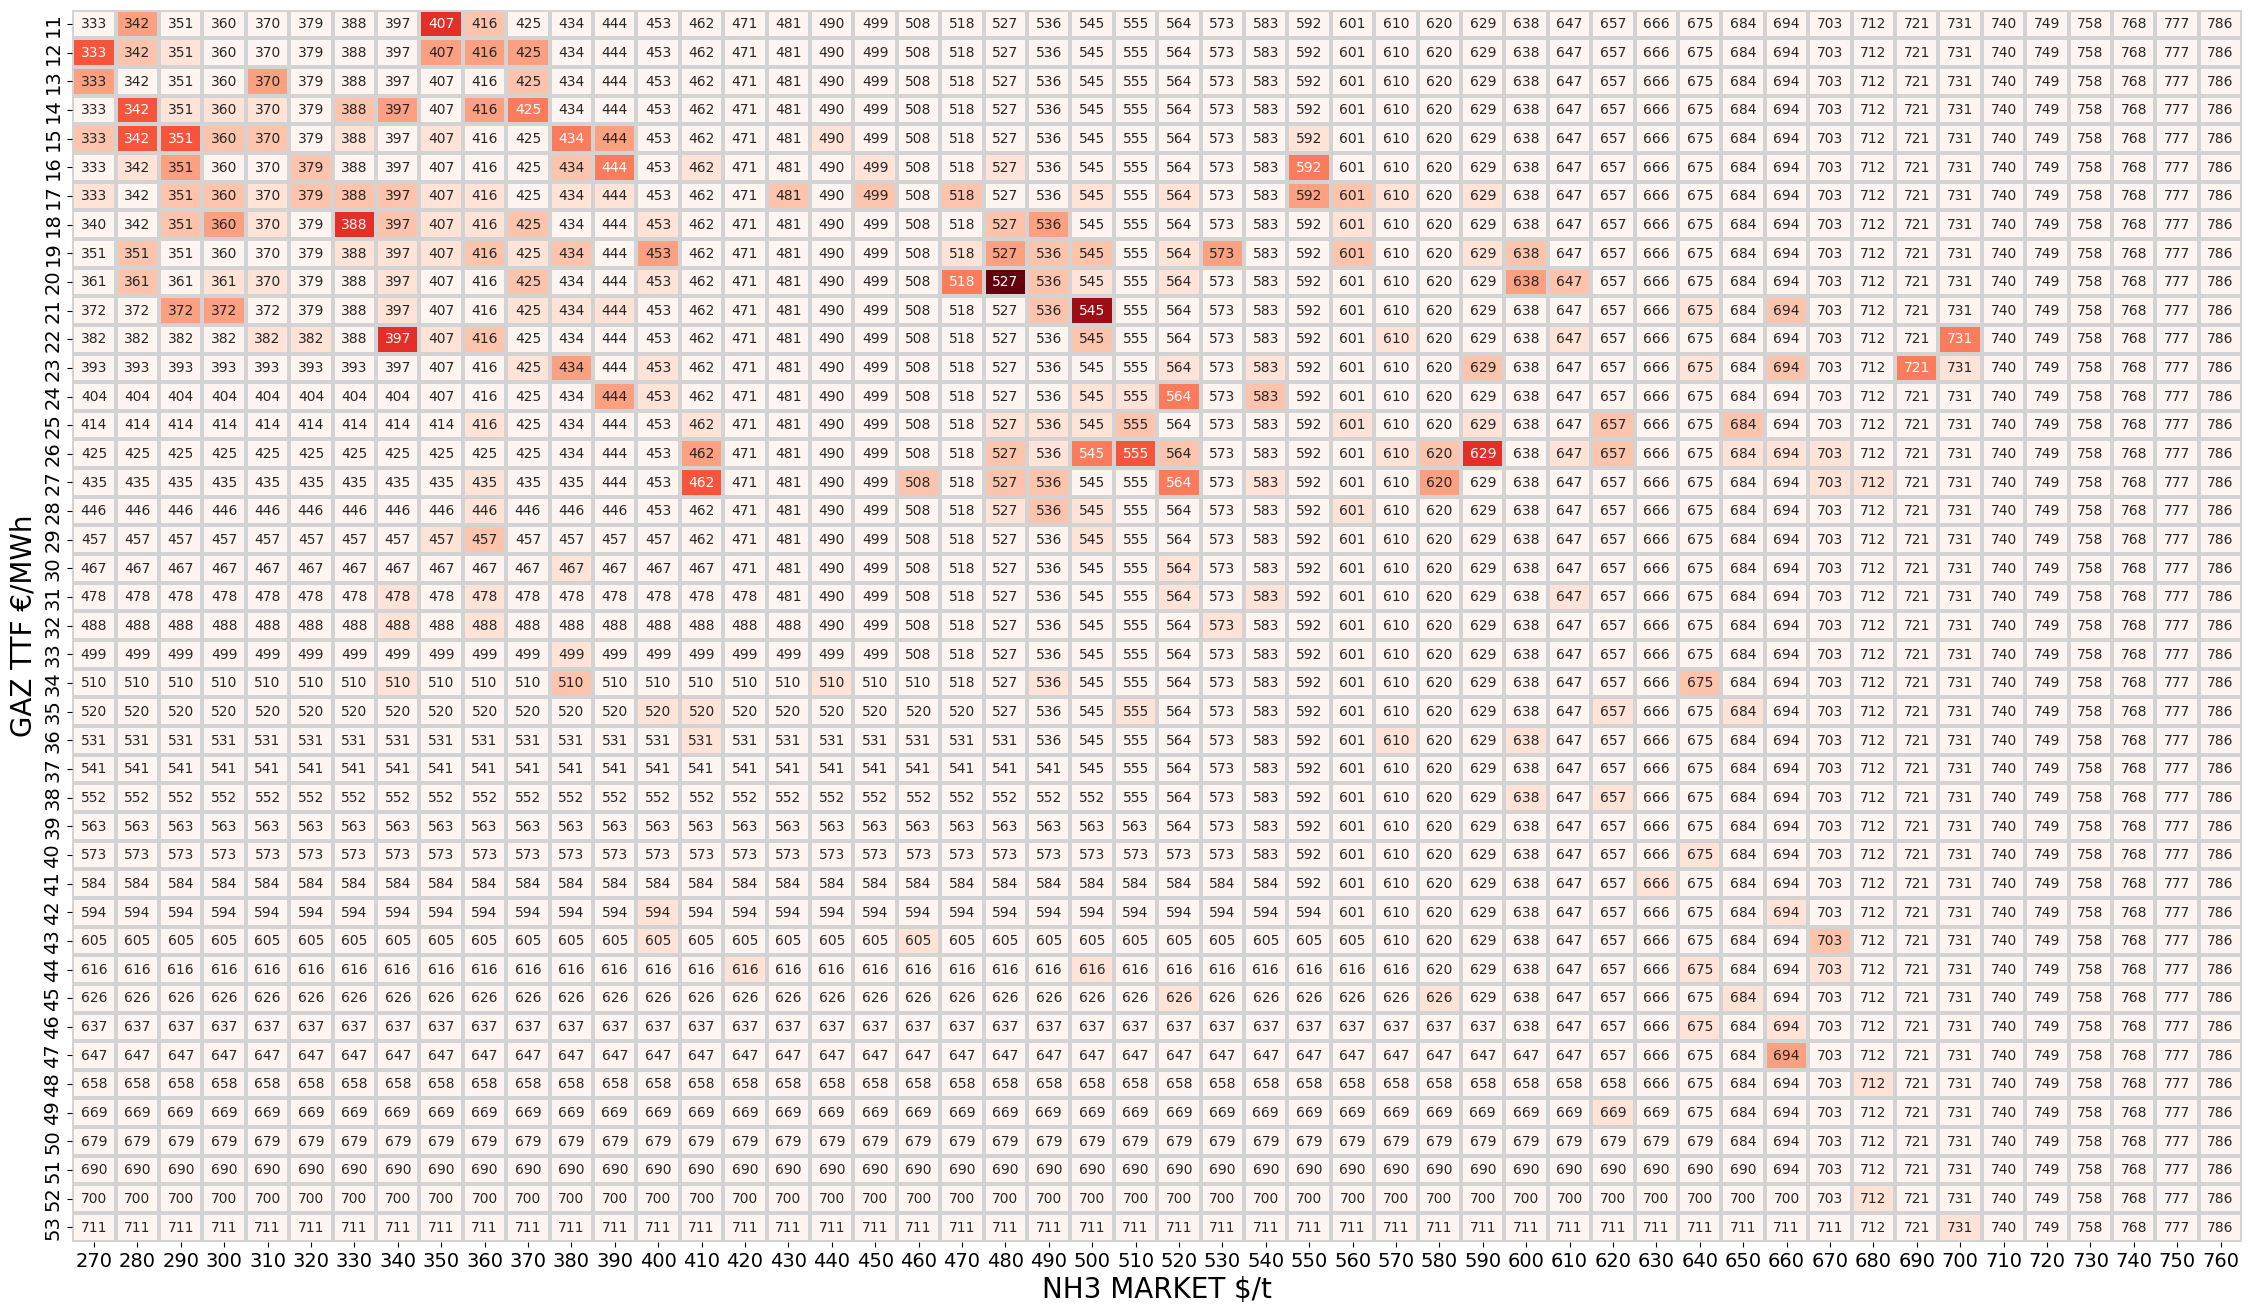

In [203]:
# Only B
fig,ax = plt.subplots(figsize=(28,16))
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#F72585","#3A0CFF", "#BBCC22", "#4CC9F0"]
plt.tick_params(bottom='on')
g = sns.heatmap(dfColor_sns.values, annot=dfB_sns,xticklabels=sns_market, yticklabels=sns_gaz, cmap='Reds' , vmin=0, vmax=maxIdxColor,cbar=False, fmt='d', linewidth=1.5, linecolor='lightgrey', ax=ax );
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('NH3 MARKET $/t',fontsize=20);
g.set_ylabel('GAZ TTF €/MWh',fontsize=20);
# ax2 = plt.twinx()
# ax2.set(ylim=(-.5, b-a+.5))
# ax2.set(xlim=(0, d-c))
# sns.scatterplot(x=x_, y=y_, hue=a_, palette=palette, s=100 , ax=ax2);
# ax2.axis('tight');
# plt.draw()


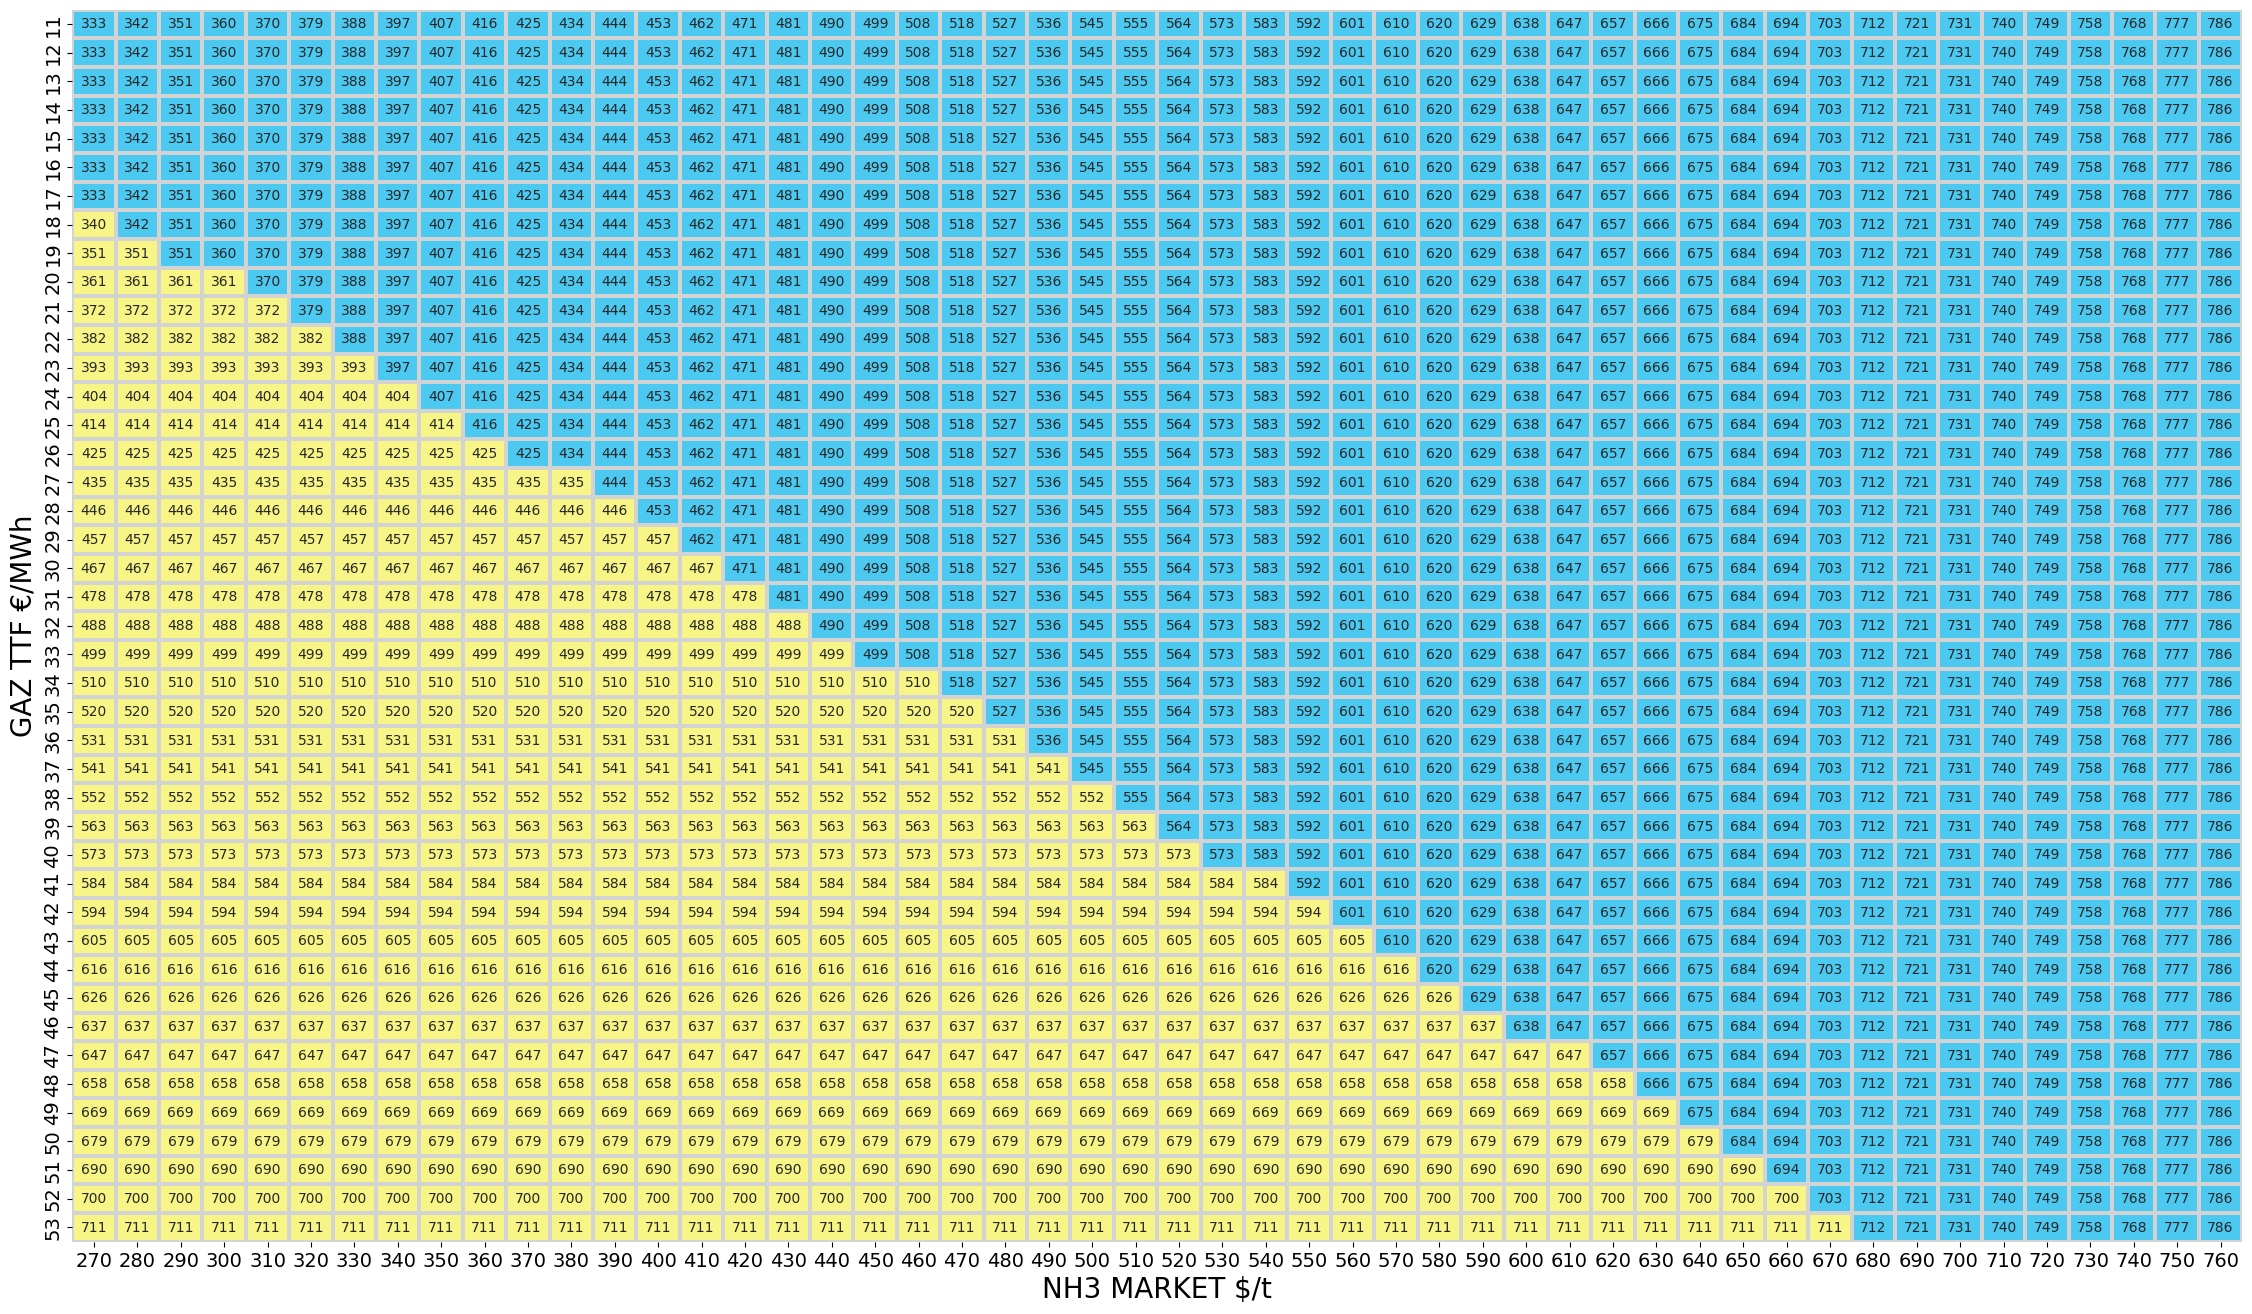

In [216]:
# Only B 
fig,ax = plt.subplots(figsize=(28,16))
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#F72585","#3A0CFF", "#BBCC22", "#4CC9F0"]
palette2 = ["#4CC9F0","#FF0CFF", "#F7f585"]
plt.tick_params(bottom='on')
g = sns.heatmap(dfBsnsColor.values,annot=dfB_sns,xticklabels=sns_market, yticklabels=sns_gaz, cmap=palette2, vmin=0, vmax=1,cbar=False, fmt='d', linewidth=1.5, linecolor='lightgrey', ax=ax );
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('NH3 MARKET $/t',fontsize=20);
g.set_ylabel('GAZ TTF €/MWh',fontsize=20);
# ax2 = plt.twinx()
# ax2.set(ylim=(-.5, b-a+.5))
# ax2.set(xlim=(0, d-c))
# sns.scatterplot(x=x_, y=y_, hue=a_, palette=palette, s=100 , ax=ax2);
# ax2.axis('tight');
# plt.draw()

In [34]:
gF = 27
mF = 410
dFiltre = data.loc[(data['TTF']<=(gF+1)) & (data['TTF']>=(gF))]
dFiltre = dFiltre.loc[(dFiltre['NH3']<=(mF+5)) & (dFiltre['NH3']>=(mF-5))]
# print(dFiltre.size/3)
print(dFiltre)
print("confirmation de la présence : ",dfColor_sns[mF][gF])

              NH3     TTF  Annee
0                               
2018-09-13  411.5  27.516   2018
2018-09-20  411.5  27.547   2018
2018-09-27  411.5  27.806   2018
2018-10-04  411.5  27.507   2018
2018-10-11  411.5   27.25   2018
confirmation de la présence :  5


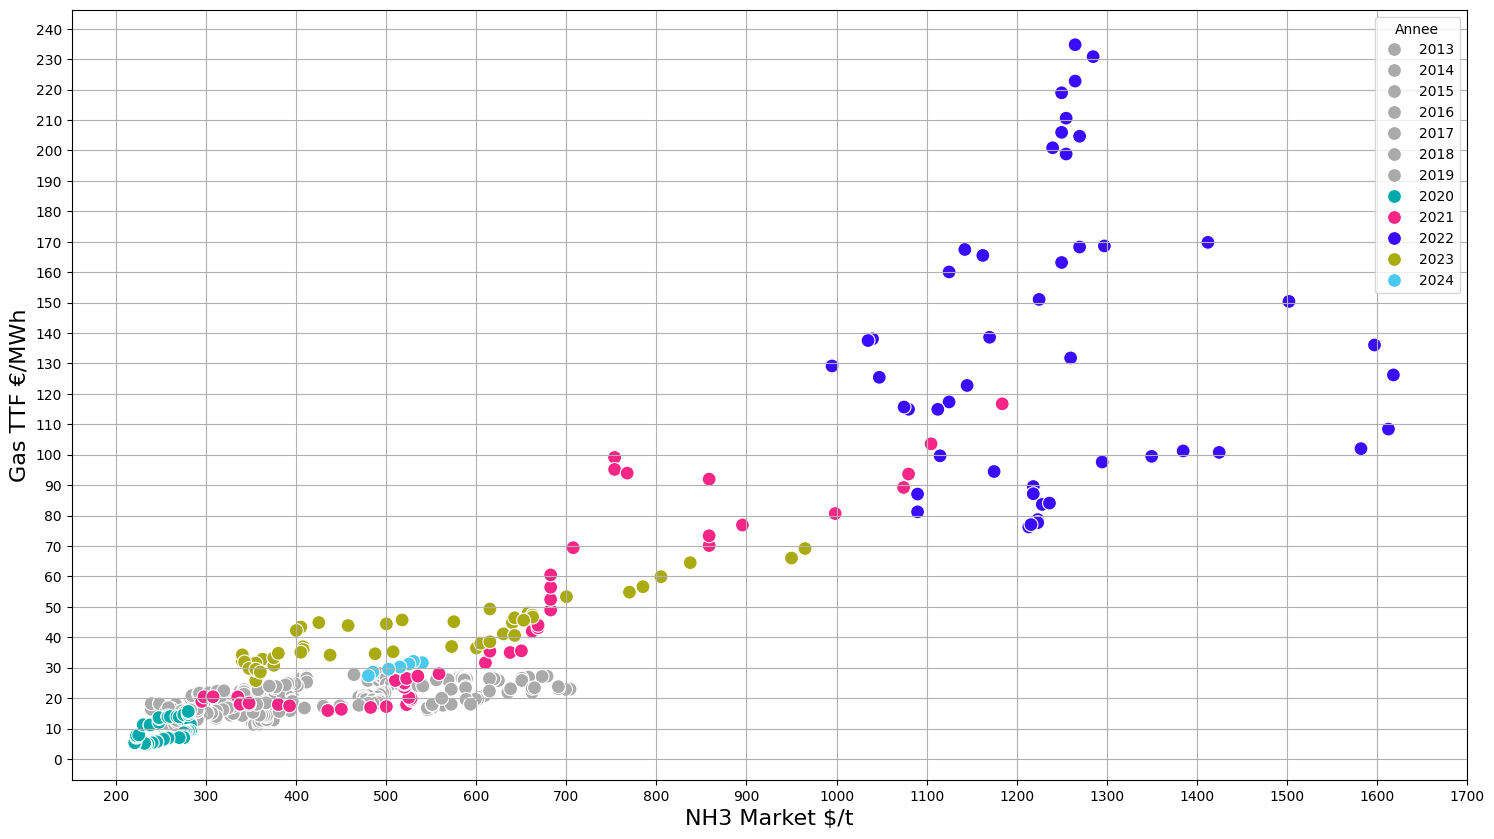

In [35]:
fig = plt.figure(figsize=(18,10))
palette = ["#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#AAAAAA","#00AAAA","#F72585","#3A0CFF", "#AAAA11", "#4CC9F0"]
g = sns.scatterplot(y=data['TTF'], x=data['NH3'],hue=data['Annee'], palette=palette, s=100);
g.set_xlabel('NH3 Market $/t',fontsize=16);
g.set_ylabel('Gas TTF €/MWh', fontsize = 16);
g.set_xticks(range(200,1800,100))
g.set_yticks(range(0,250,10))
g.grid()

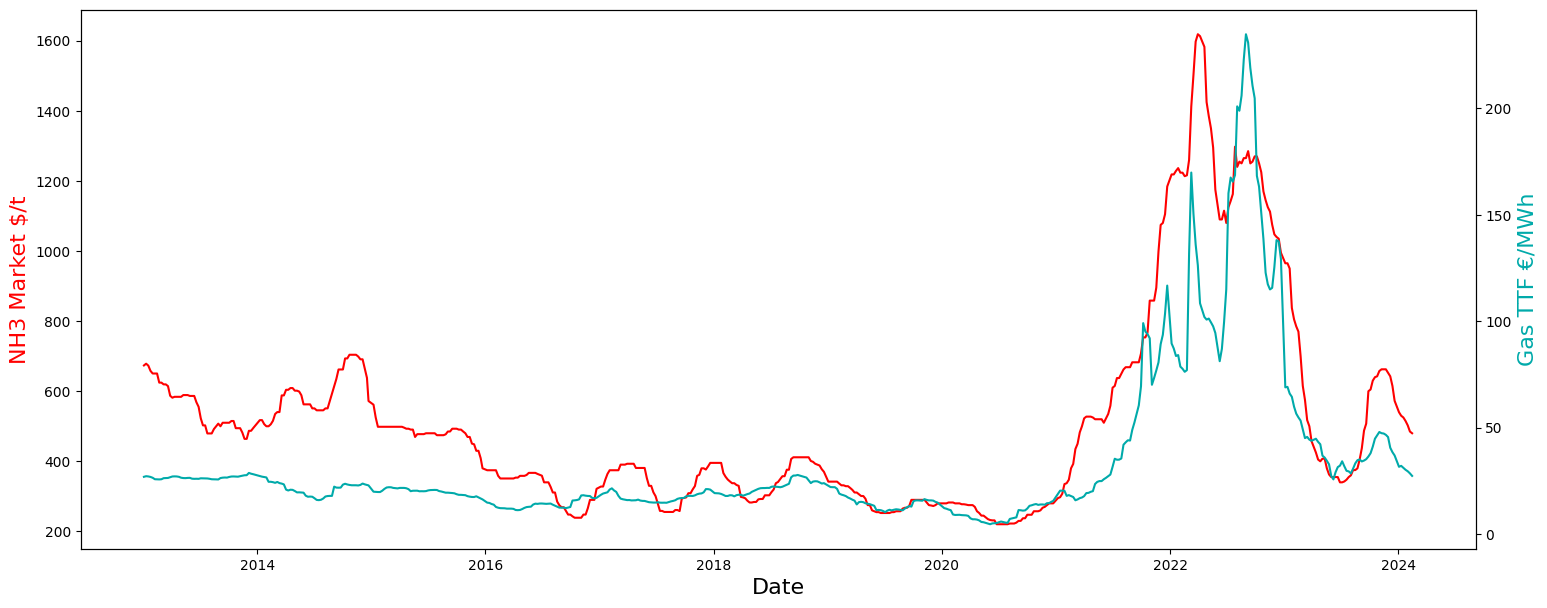

In [36]:
fig,ax1 = plt.subplots(figsize=(18,7))
g = sns.lineplot(data=data['NH3'],ax=ax1, color='Red')
ax2=plt.twinx()
g2 = sns.lineplot(data=data['TTF'],ax=ax2, color="#00AAAA")
g.set_ylabel('NH3 Market $/t',fontsize=16, color='Red');
g.set_xlabel('Date',fontsize=16);
g2.set_ylabel('Gas TTF €/MWh',fontsize=16, color='#00AAAA');


          NH3       TTF
NH3  1.000000  0.862069
TTF  0.862069  1.000000


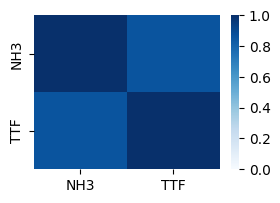

In [37]:
corr=data[['NH3','TTF']].corr()
print(corr)
fig=plt.figure(figsize=(3,2))
sns.heatmap(data=corr, cmap='Blues',vmax=1,vmin=0);